In [ ]:
# ========== STEP 0: INSTALL DEPENDENCIES ==========
!pip install flwr tensorflow==2.18.1 numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.1/598.1 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found exist

In [ ]:
!pip install -U "flwr[simulation]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 9.6 MB/s eta 0:00:00


In [ ]:
# ========== STEP 0: INSTALL DEPENDENCIES ==========
!pip install flwr tensorflow==2.18.1 numpy==1.26.4
!pip install -U "flwr[simulation]"

In [ ]:
# Step 1: Import packages
import flwr as fl
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import backend as K

In [ ]:
# Step 2: Mount and Load processed data
from google.colab import drive
drive.mount('/content/drive')

X_resampled = np.load('/content/drive/MyDrive/dataSaved/X.npy')
y_resampled = np.load('/content/drive/MyDrive/dataSaved/y.npy')
# X_test = np.load('/content/drive/MyDrive/dataSaved/X_test.npy')
# y_test = np.load('/content/drive/MyDrive/dataSaved/y_test.npy')
# X_train = np.load('/content/drive/MyDrive/dataSaved/X_train.npy')
# y_train = np.load('/content/drive/MyDrive/dataSaved/y_train.npy')

X = X_resampled
y = y_resampled

Mounted at /content/drive


/tmp/ipython-input-3-4122545303.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Label', y='Percentage', data=label_dist, palette='viridis', width=0.4)


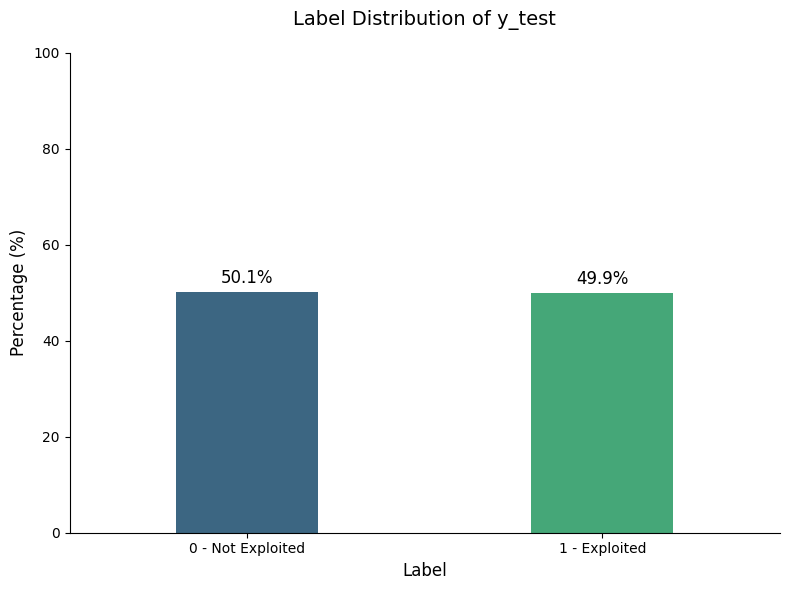

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Map 0 -> Not Exploited, 1 -> Exploited
label_map = {0: '0 - Not Exploited', 1: '1 - Exploited'}
label_dist = (pd.Series(y_resampled)
              .map(label_map)
              .value_counts(normalize=True)
              .sort_index()
              .mul(100)
              .round(2)
              .rename_axis('Label')
              .reset_index(name='Percentage'))

# Create bar plot with thinner bars
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Label', y='Percentage', data=label_dist, palette='viridis', width=0.4)

# Titles and labels
plt.title('Label Distribution of y_test', fontsize=14, pad=20)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.ylim(0, 100)

# Annotate each bar with its value
for p in ax.patches:
    ax.annotate(f'{p.get_height()}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import flwr as fl
from tensorflow.keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')

# MODEL_PATH = "/content/drive/MyDrive/FL/finalcentrlizedmodel.h5"
MODEL_PATH = "/content/drive/MyDrive/dataSaved/finally_model.h5"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Added stratify for balanced split
# Step 4: Function to create client-specific train/test data
def create_client_data(X_data, y_data, n_clients=5):
    split_data = []
    # Use train_test_split to get indices for a clean split for each client
    # Shuffle the data before splitting among clients to ensure heterogeneity
    indices = np.arange(len(X_data))
    np.random.shuffle(indices) # Shuffle indices
    shuffled_X = X_data[indices]
    shuffled_y = y_data[indices]

    size = len(shuffled_X) // n_clients
    for i in range(n_clients):
        start = i * size
        # Ensure the last client gets the remaining data if division is not exact
        end = (i + 1) * size if i < n_clients - 1 else len(shuffled_X)
        split_data.append((shuffled_X[start:end], shuffled_y[start:end]))
    return split_data

# Create client-specific *training* data and *testing* data
train_clients_data = create_client_data(X_train_all, y_train_all, n_clients=5)
test_clients_data = create_client_data(X_test_all, y_test_all, n_clients=5)

# Now, train_clients_data[i] is the training data for client i

In [ ]:
# # class FLClient(fl.client.NumPyClient):
# #     def __init__(self, model, train_data, test_data, client_id):
# #         self.model = model
# #         self.train_data = train_data
# #         self.test_data = test_data
# #         self.client_id = client_id

# #     def get_parameters(self, config):
# #         return self.model.get_weights()

# #     def fit(self, parameters, config):
# #         self.model.set_weights(parameters)
# #         return self.model.get_weights(), len(self.train_data[0]), {}

# #     def evaluate(self, parameters, config):
# #         self.model.set_weights(parameters)
# #         X_test, y_test = self.test_data
# #         y_pred_prob = self.model.predict(X_test).ravel()
# #         y_pred = (y_pred_prob > 0.4).astype(int)

# #         acc = accuracy_score(y_test, y_pred)
# #         prec = precision_score(y_test, y_pred)
# #         rec = recall_score(y_test, y_pred)
# #         f1 = f1_score(y_test, y_pred)
# #         auc = roc_auc_score(y_test, y_pred_prob)
# #         cm = confusion_matrix(y_test, y_pred)

# #         print(f"\n--- Client {self.client_id} Evaluation ---")
# #         print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
# #         print("Confusion Matrix:")
# #         print(cm)

# #         return 0.0, len(X_test), {"accuracy": acc, "auc": auc}
# #-----------------------------------------------------------------------------------------------------------------------

# # from flwr.client import NumPyClient

# # def client_fn(context):
# #     cid = int(context.client_id)  # من الفئة الجديدة Context
# #     model = load_model(MODEL_PATH, compile=False)
# #     model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC()])

# #     class WrappedClient(NumPyClient):
# #         def get_parameters(self, config):
# #             return model.get_weights()

# #         def fit(self, parameters, config):
# #             model.set_weights(parameters)
# #             return model.get_weights(), len(train_clients[cid][0]), {}

# #         def evaluate(self, parameters, config):
# #             model.set_weights(parameters)
# #             X_test, y_test = test_clients[cid]
# #             y_pred_prob = model.predict(X_test).ravel()
# #             y_pred = (y_pred_prob > 0.4).astype(int)

# #             acc = accuracy_score(y_test, y_pred)
# #             prec = precision_score(y_test, y_pred)
# #             rec = recall_score(y_test, y_pred)
# #             f1 = f1_score(y_test, y_pred)
# #             auc = roc_auc_score(y_test, y_pred_prob)
# #             cm = confusion_matrix(y_test, y_pred)

# #             print(f"\n--- Client {cid} Evaluation ---")
# #             print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
# #             print("Confusion Matrix:\n", cm)

# #             return 0.0, len(X_test), {"accuracy": acc, "auc": auc}

# #     return WrappedClient().to_client()  # ✅ الحل الجديد الرسمي من Flower

# #------------------------------------------------------------------------------------------------------------------------------------

#main....
# from flwr.client import NumPyClient
# from tensorflow.keras.models import load_model
# import tensorflow as tf
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
# import flwr as fl # Ensure fl is imported

# # Assuming MODEL_PATH is defined in a previous cell
# # Assuming train_clients and test_clients are defined in a previous cell

# # Step 8: Define client function and start simulation
# # Change the signature to accept 'cid' instead of 'context'
# def client_fn(cid: str):
#     cid_int = int(cid)  # Convert client ID string to integer
#     model = load_model(MODEL_PATH, compile=False)
#     model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC()])

#     # Define the WrappedClient inside client_fn
#     class WrappedClient(NumPyClient):
#         def get_parameters(self, config):
#             return model.get_weights()

#         def fit(self, parameters, config):
#             model.set_weights(parameters)
#             # Add fitting logic if you intend to train the model
#             # model.fit(train_clients[cid_int][0], train_clients[cid_int][1], epochs=1, batch_size=32)
#             return model.get_weights(), len(train_clients[cid_int][0]), {}

#         def evaluate(self, parameters, config):
#             model.set_weights(parameters)
#             X_test, y_test = test_clients[cid_int]
#             y_pred_prob = model.predict(X_test).ravel()
#             y_pred = (y_pred_prob > 0.4).astype(int)

#             acc = accuracy_score(y_test, y_pred)
#             prec = precision_score(y_test, y_pred)
#             rec = recall_score(y_test, y_pred)
#             f1 = f1_score(y_test, y_pred)
#             auc = roc_auc_score(y_test, y_pred_prob)
#             cm = confusion_matrix(y_test, y_pred)

#             print(f"\n--- Client {cid_int} Evaluation ---")
#             print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
#             print("Confusion Matrix:\n", cm)

#             return 0.0, len(X_test), {"accuracy": acc, "auc": auc}

#     # Return an instance of the wrapped client
#     return WrappedClient()

# # Ensure the CustomFedAvg strategy is defined if you intend to use it
# # If not, use the default FedAvg strategy
# # from flwr.server.strategy import FedAvg
# # strategy = FedAvg(...)

# from flwr.common import Scalar
# import flwr as fl # Explicitly import flwr

# # Assuming CustomFedAvg is defined in a previous cell
# # If not, use the default FedAvg strategy:
# # from flwr.server.strategy import FedAvg
# # strategy = FedAvg(
# #     fraction_fit=1.0,
# #     min_evaluate_clients=3,
# #     min_fit_clients=3,
# #     min_available_clients=3,
# # )

# # If using the CustomFedAvg strategy defined in a previous cell, uncomment the line below:
# # strategy = CustomFedAvg()


# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=3,
#     config=fl.server.ServerConfig(num_rounds=5),
#     strategy=strategy, # Use your defined strategy here
#     # Set client resources for Ray if needed, e.g., for CPU or GPU allocation
#     # client_resources={"num_cpus": 1, "num_gpus": 0.1}
# )

#----***********************************--------------

from flwr.client import NumPyClient
from tensorflow.keras.models import load_model
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import flwr as fl # Ensure fl is imported
import matplotlib.pyplot as plt # Import for plotting
import numpy as np # Import numpy

# Assuming build_model and focal_loss functions are defined in previous cells
# Assuming train_clients_data and test_clients_data are defined above

# Step 6: Define the Flower client class with evaluation
class FLClient(fl.client.NumPyClient):
    # Update init to take client-specific train and test data
    def __init__(self, model, train_data, test_data, client_id):
        self.model = model
        self.train_data = train_data
        self.test_data = test_data # This will now be the client's specific test data
        self.client_id = client_id
        # Log class distribution
        print(f"Client {client_id} training class distribution: {np.bincount(train_data[1].astype(int))}")
        print(f"Client {client_id} testing class distribution: {np.bincount(test_data[1].astype(int))}")


    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        # Ensure you have fitting logic here if you want clients to train
        # Example fit logic (uncomment if you are training)
        # print(f"Client {self.client_id} training on {len(self.train_data[0])} samples")
        # history = self.model.fit(self.train_data[0], self.train_data[1],
        #                         epochs=config["local_epochs"], # Get epochs from config
        #                         batch_size=config["batch_size"], # Get batch size from config
        #                         verbose=0)
        # training_loss = history.history['loss'][-1] if history.history['loss'] else 0
        # print(f"Client {self.client_id} training loss: {training_loss:.4f}")

        # If clients are *not* training in this simulation run, just return parameters and dataset size
        # This would be the case if you're just evaluating a pre-trained model across clients
        training_loss = 0 # Placeholder if no training occurs in fit
        print(f"Client {self.client_id} Fit called with {len(self.train_data[0])} samples (no training performed in this example)")


        tf.keras.backend.clear_session()  # Clear memory
        # Return the *received* parameters if no training happened, or updated weights if training happened
        return self.model.get_weights(), len(self.train_data[0]), {"training_loss": training_loss}


    def evaluate(self, parameters, config):
        # The client receives the aggregated global model parameters
        self.model.set_weights(parameters)

        # *** Evaluation is now performed on the client's OWN test data ***
        X_test_client, y_test_client = self.test_data

        print(f"Client {self.client_id} evaluating on {len(X_test_client)} samples from its local test set.")

        y_pred_prob = self.model.predict(X_test_client, batch_size=32, verbose=0).ravel()
        # Use the threshold from config or a default
        threshold = config.get("eval_threshold", 0.5) # Get threshold from config, default to 0.5
        y_pred = (y_pred_prob > threshold).astype(int)

        acc = accuracy_score(y_test_client, y_pred)
        prec = precision_score(y_test_client, y_pred, zero_division=0) # handle potential zero division
        rec = recall_score(y_test_client, y_pred, zero_division=0)   # handle potential zero division
        f1 = f1_score(y_test_client, y_pred, zero_division=0)     # handle potential zero division
        auc = roc_auc_score(y_test_client, y_pred_prob) if len(np.unique(y_test_client)) > 1 else 0.0 # Handle case with only one class
        cm = confusion_matrix(y_test_client, y_pred)

        print(f"\n--- Client {self.client_id} Evaluation (Round {config.get('server_round', 'N/A')}) ---")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC: {auc:.4f}")
        print("Confusion Matrix:")
        print(cm)
        print("-----------------------------")

        # Plot confusion matrix (optional, can generate many plots)
        # plt.figure(figsize=(5, 5))
        # plt.imshow(cm, cmap='Blues')
        # plt.title(f'Client {self.client_id} CM (Round {config.get("server_round", "N/A")})')
        # plt.colorbar()
        # plt.xlabel('Predicted')
        # plt.ylabel('Actual')
        # plt.xticks([0, 1], ['Negative', 'Positive'])
        # plt.yticks([0, 1], ['Negative', 'Positive'])
        # for i in range(2):
        #     for j in range(2):
        #         plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
        # plt.tight_layout()
        # plt.savefig(f'client_{self.client_id}_round_{config.get("server_round", "N/A")}_cm.png')
        # plt.close()

        tf.keras.backend.clear_session()  # Clear memory
        return 0.0, len(X_test_client), {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc, "confusion_matrix": cm.tolist()} # Return CM as list
# Step 8: Define client function and start simulation

# This function is called by Flower for each client cid
def client_fn(cid: str):
    cid_int = int(cid)
    model = build_model(X_train_all.shape[1]) # Build a new model instance for each client

    # Pass the client's specific training and testing data
    client_train_data = train_clients_data[cid_int]
    client_test_data = test_clients_data[cid_int]

    # If you are starting with a pre-trained model, you might load it here
    # if MODEL_PATH:
    #     try:
    #         initial_model = load_model(MODEL_PATH, compile=False, custom_objects={'focal_loss_fixed': focal_loss()})
    #         model.set_weights(initial_model.get_weights())
    #         print(f"Client {cid} loaded initial model weights.")
    #     except Exception as e:
    #         print(f"Client {cid} could not load initial model from {MODEL_PATH}: {e}")


    return FLClient(model, client_train_data, client_test_data, client_id=cid_int) # Pass cid_int

# Define your strategy (you can use the default FedAvg or your CustomFedAvg)
# You might need to pass the initial global model weights to the strategy if starting fresh
# from flwr.server.strategy import FedAvg
# strategy = FedAvg(
#     fraction_fit=1.0,
#     fraction_evaluate=1.0, # Evaluate on all clients
#     min_fit_clients=3,
#     min_evaluate_clients=3,
#     min_available_clients=3,
#     # on_evaluate_config_fn=lambda rnd: {"eval_threshold": 0.5, "server_round": rnd}, # Pass config to evaluate
#     # on_fit_config_fn=lambda rnd: {"local_epochs": 1, "batch_size": 32}, # Pass config to fit (if training)
# )

# If using your CustomFedAvg, ensure it's defined and imported or in the same cell
from flwr.common import Scalar
import flwr as fl

# Assuming CustomFedAvg is defined in a previous cell, or redefine it here if necessary
class CustomFedAvg(fl.server.strategy.FedAvg):
    def aggregate_evaluate(self, rnd, results, failures):
        # ... your aggregation logic ...
        return super().aggregate_evaluate(rnd, results, failures)
strategy = CustomFedAvg( # Or use FedAvg(...) if you don't need custom aggregation
    fraction_fit=1.0,
    fraction_evaluate=1.0, # Ensure all clients evaluate
    min_fit_clients=5,
    min_evaluate_clients=5,
    min_available_clients=5,
    # Pass the round number and threshold to the client's evaluate method
    on_evaluate_config_fn=lambda rnd, _: {"eval_threshold": 0.5, "server_round": rnd},
    # If you are training, pass fit config
    # on_fit_config_fn=lambda rnd, _: {"local_epochs": 1, "batch_size": 32},
)


# Set client resources for Ray
client_resources = {"num_cpus": 1, "num_gpus": 0}  # Use CPU to avoid GPU memory issues

print("Starting simulation with clients evaluating on their local test data...")

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=5,
    config=fl.server.ServerConfig(num_rounds=5), # Adjust num_rounds as needed
    strategy=strategy,
    client_resources=client_resources
)


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout


Starting simulation with clients evaluating on their local test data...


2025-06-21 23:01:35,970	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7966430823.0, 'object_store_memory': 3983215411.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=4458) 2025-06-21 23:01:43.115446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=4458) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=4458) E0000 00:00:1750546903.192595    4458 cuda

RuntimeError: Simulation crashed.

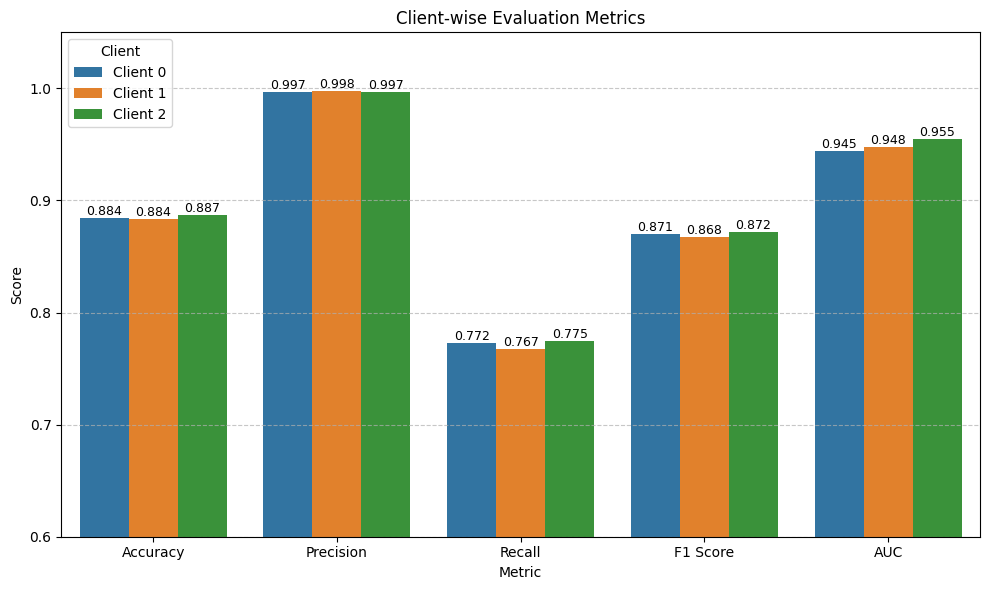

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# بيانات العملاء
data = {
    "Client": ["Client 0", "Client 1", "Client 2"],
    "Accuracy": [0.8840, 0.8838, 0.8872],
    "Precision": [0.9970, 0.9979, 0.9969],
    "Recall": [0.7725, 0.7672, 0.7749],
    "F1 Score": [0.8705, 0.8675, 0.8720],
    "AUC": [0.9445, 0.9480, 0.9545]
}

# تحويل إلى DataFrame
df = pd.DataFrame(data)
df_melted = df.melt(id_vars="Client", var_name="Metric", value_name="Score")

# إعداد الشكل
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_melted, x="Metric", y="Score", hue="Client")

# كتابة القيم فوق الأعمدة
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.3f}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9, color='black')

# تنسيق الشكل
plt.title("Client-wise Evaluation Metrics")
plt.ylim(0.6, 1.05)
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Client")
plt.tight_layout()

# عرض الرسم
plt.show()


In [ ]:
# # Step 6: Define the Flower client class with evaluation

# class FLClient(fl.client.NumPyClient):
#     def __init__(self, model, train_data, test_data, client_id):
#         self.model = model
#         self.train_data = train_data
#         self.test_data = test_data
#         self.client_id = client_id

#     def get_parameters(self, config):
#         return self.model.get_weights()

#     def fit(self, parameters, config):
#         self.model.set_weights(parameters)
#         self.model.fit(self.train_data[0], self.train_data[1],
#                        epochs=30, batch_size=8, verbose=0)
#         return self.model.get_weights(), len(self.train_data[0]), {}

#     def evaluate(self, parameters, config):
#         self.model.set_weights(parameters)
#         X_test, y_test = self.test_data
#         y_pred_prob = self.model.predict(X_test).ravel()
#         y_pred = (y_pred_prob > 0.4).astype(int)

#         acc = accuracy_score(y_test, y_pred)
#         prec = precision_score(y_test, y_pred)
#         rec = recall_score(y_test, y_pred)
#         f1 = f1_score(y_test, y_pred)
#         auc = roc_auc_score(y_test, y_pred_prob)
#         cm = confusion_matrix(y_test, y_pred)

#         print(f"\n--- Client {self.client_id} Evaluation ---")
#         print(f"Accuracy: {acc:.4f}")
#         print(f"Precision: {prec:.4f}")
#         print(f"Recall: {rec:.4f}")
#         print(f"F1 Score: {f1:.4f}")
#         print(f"AUC: {auc:.4f}")
#         print("Confusion Matrix:")
#         print(cm)
#         print("-----------------------------")

#                 # Plot confusion matrix
#         plt.figure(figsize=(5, 5))
#         plt.imshow(cm, cmap='Blues')
#         plt.title(f'Client {self.client_id} Confusion Matrix')
#         plt.colorbar()
#         plt.xlabel('Predicted')
#         plt.ylabel('Actual')
#         plt.xticks([0, 1], ['Negative', 'Positive'])
#         plt.yticks([0, 1], ['Negative', 'Positive'])
#         for i in range(2):
#             for j in range(2):
#                 plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
#         plt.tight_layout()
#         plt.savefig(f'client_{self.client_id}_cm.png')
#         plt.close()

#         return 0.0, len(X_test), {"accuracy": acc, "auc": auc}


In [ ]:
# def client_fn(cid):
#     cid = int(cid)
#     model = load_model(MODEL_PATH, compile=False)
#     model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC()])
#     return FLClient(model, train_clients[cid], test_clients[cid], cid)

# strategy = fl.server.strategy.FedAvg(
#     fraction_fit=1.0,
#     fraction_evaluate=1.0, # Changed from min_eval_clients to fraction_evaluate
#     min_fit_clients=3,
#     min_evaluate_clients=3, # Corrected argument name
#     min_available_clients=3,
# )

# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=3,
#     config=fl.server.ServerConfig(num_rounds=5),
#     strategy=strategy
# )

#-------------------------------------------------------------------------------------------------------------------------------

from flwr.common import Scalar
import flwr as fl # Explicitly import flwr

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    # Changed from min_eval_clients to min_evaluate_clients as per Flower documentation
    min_evaluate_clients=3,
    min_fit_clients=3,
    min_available_clients=3,
)

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy
)

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
2025-06-20 15:04:07,946	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 2.0, 'object_store_memory': 3983065497.0, 'node:172.28.0.12': 1.0, 'memory': 7966130996.0, 'GPU': 1.0, 'accelerator_type:T4': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Re

RuntimeError: Simulation crashed.

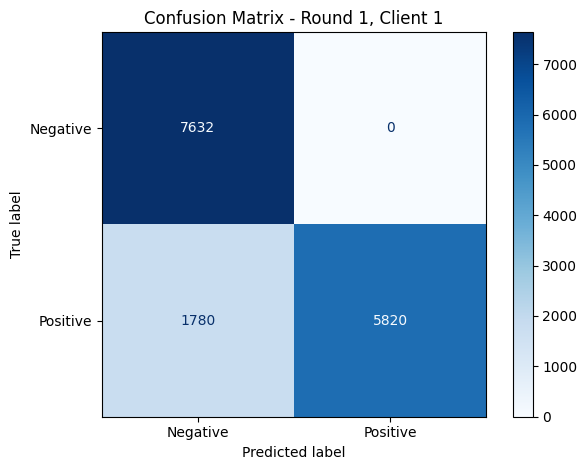

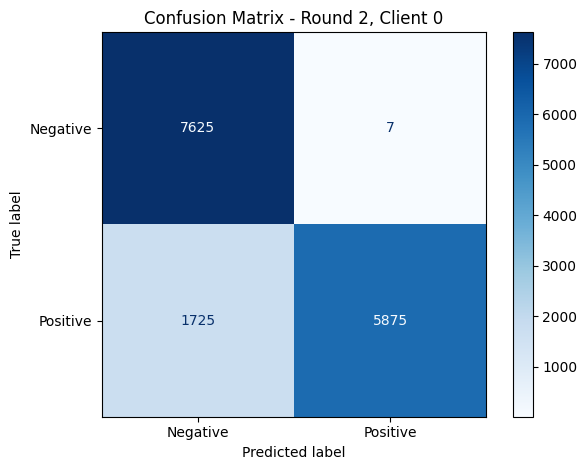

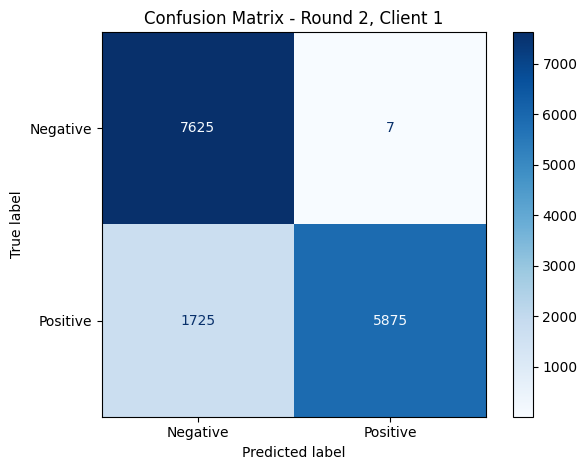

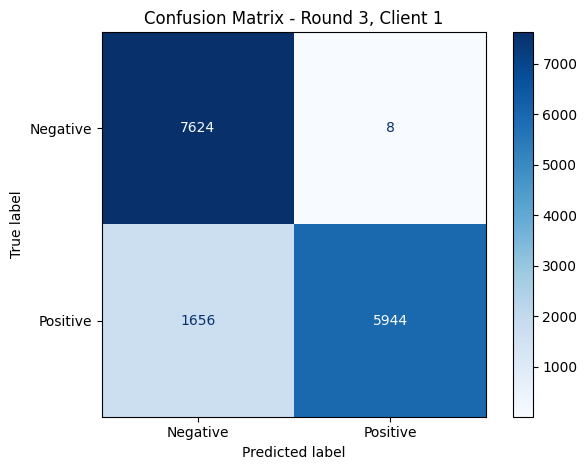

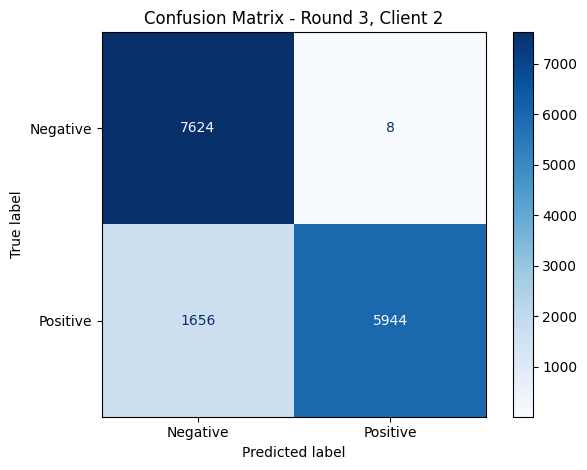

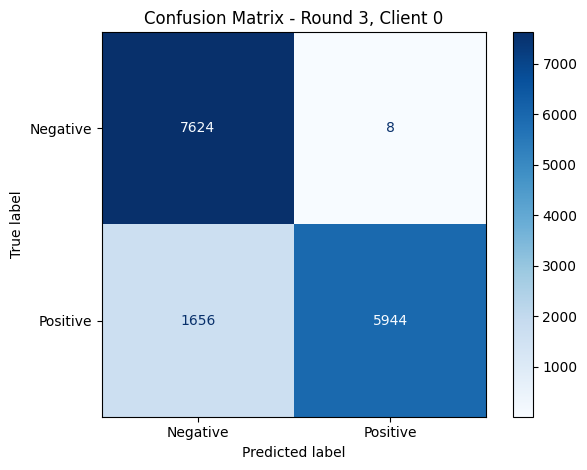

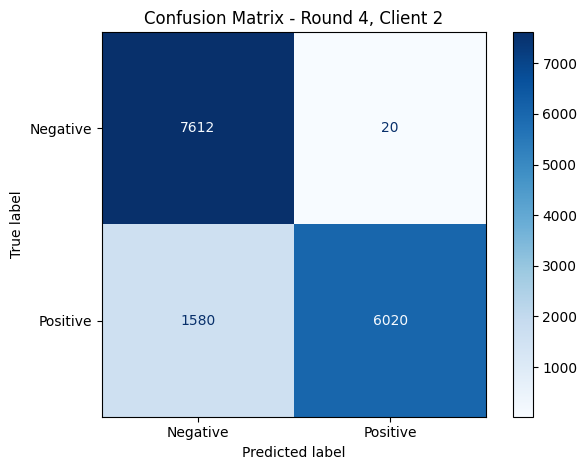

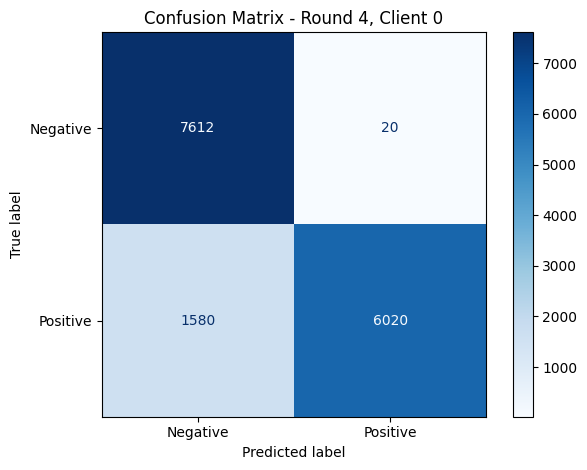

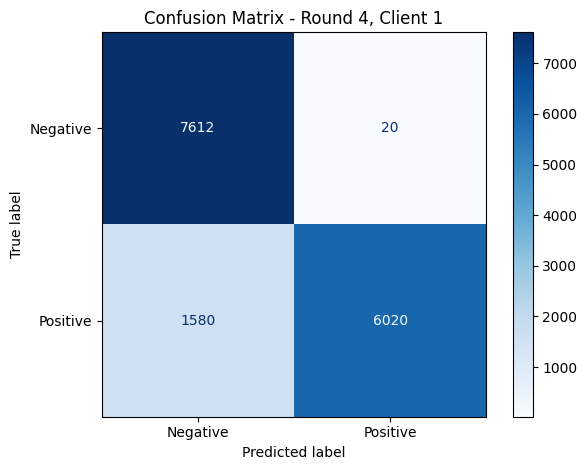

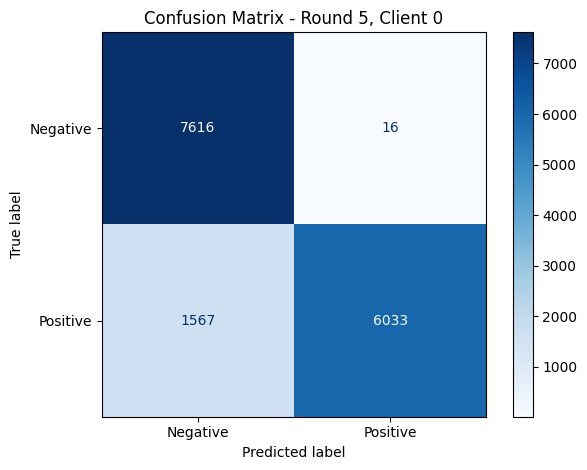

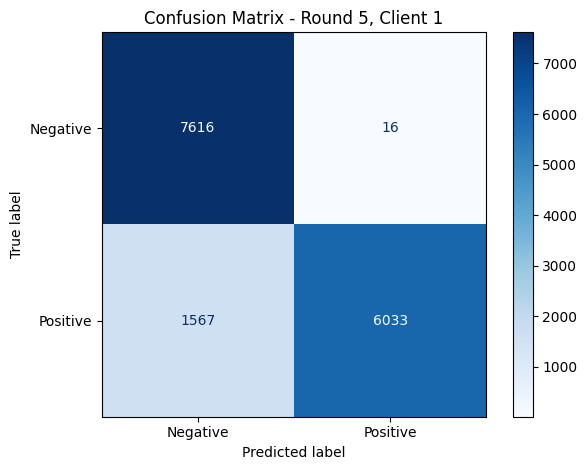

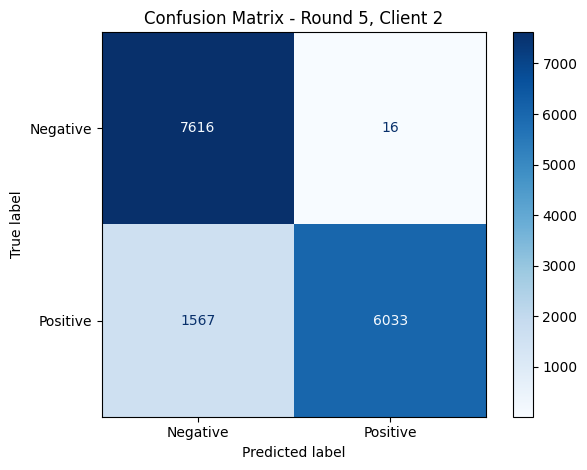

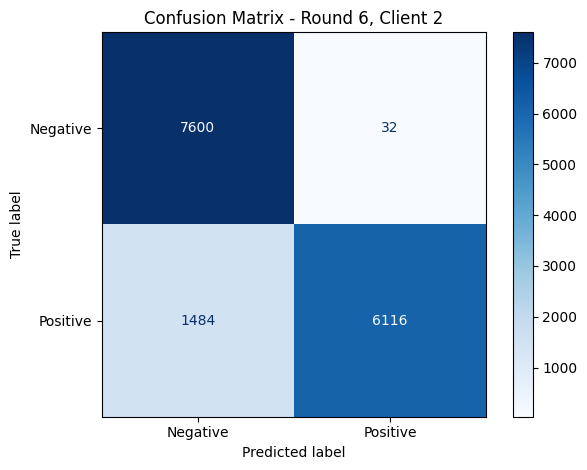

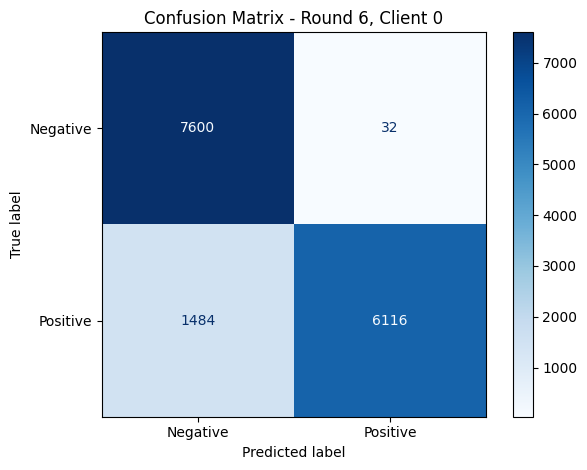

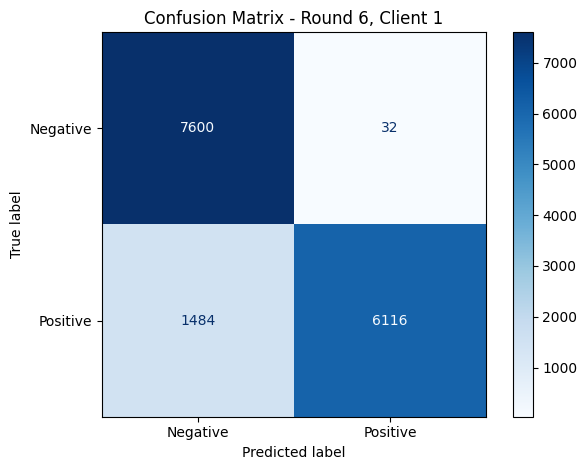

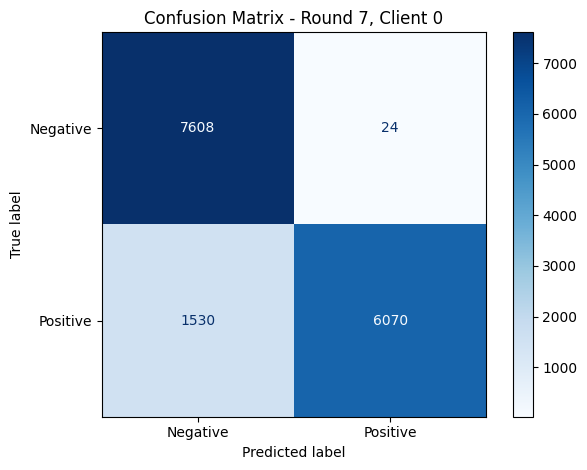

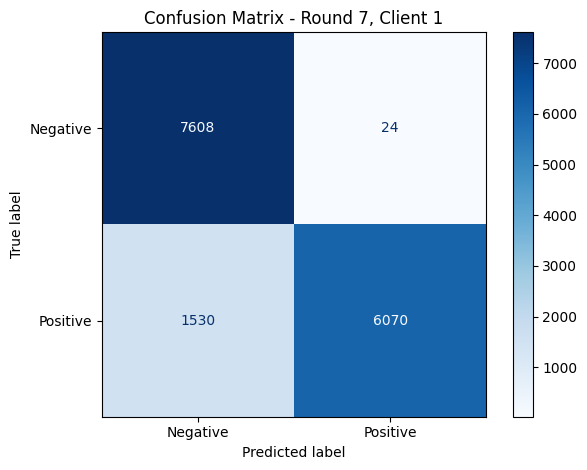

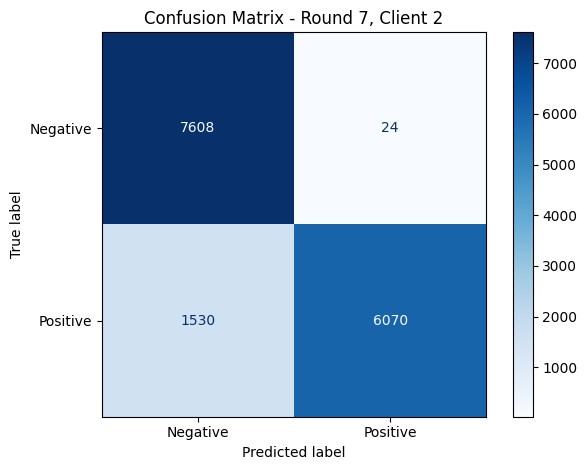

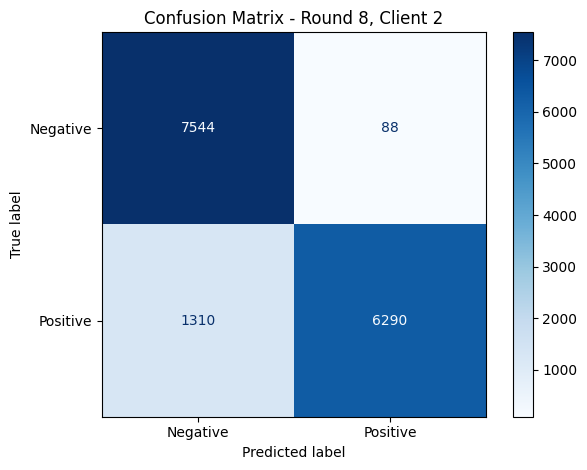

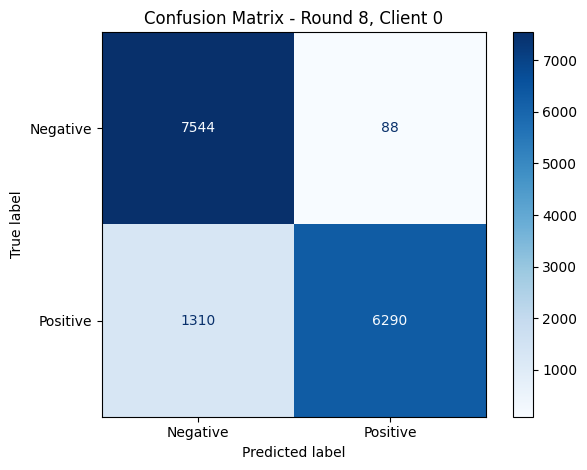

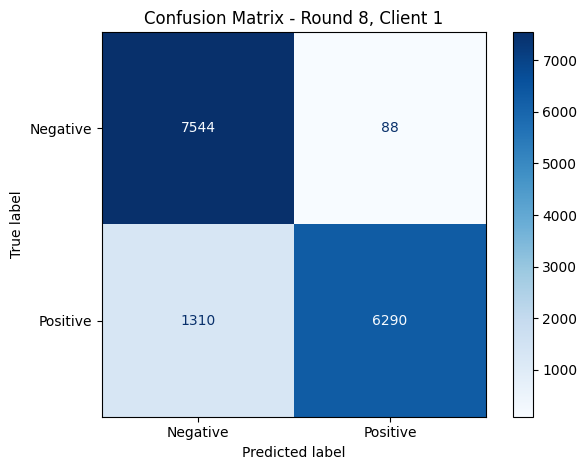

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Data for each client in the format (Round, Client, [[TN, FP], [FN, TP]])
confusion_data = [
    (1, 'Client 1', [[7632, 0], [1780, 5820]]),
    (2, 'Client 0', [[7625, 7], [1725, 5875]]),
    (2, 'Client 1', [[7625, 7], [1725, 5875]]),
    (3, 'Client 1', [[7624, 8], [1656, 5944]]),
    (3, 'Client 2', [[7624, 8], [1656, 5944]]),
    (3, 'Client 0', [[7624, 8], [1656, 5944]]),
    (4, 'Client 2', [[7612, 20], [1580, 6020]]),
    (4, 'Client 0', [[7612, 20], [1580, 6020]]),
    (4, 'Client 1', [[7612, 20], [1580, 6020]]),
    (5, 'Client 0', [[7616, 16], [1567, 6033]]),
    (5, 'Client 1', [[7616, 16], [1567, 6033]]),
    (5, 'Client 2', [[7616, 16], [1567, 6033]]),
    (6, 'Client 2', [[7600, 32], [1484, 6116]]),
    (6, 'Client 0', [[7600, 32], [1484, 6116]]),
    (6, 'Client 1', [[7600, 32], [1484, 6116]]),
    (7, 'Client 0', [[7608, 24], [1530, 6070]]),
    (7, 'Client 1', [[7608, 24], [1530, 6070]]),
    (7, 'Client 2', [[7608, 24], [1530, 6070]]),
    (8, 'Client 2', [[7544, 88], [1310, 6290]]),
    (8, 'Client 0', [[7544, 88], [1310, 6290]]),
    (8, 'Client 1', [[7544, 88], [1310, 6290]]),
]

# Plot each confusion matrix
for round_num, client_name, matrix in confusion_data:
    matrix_np = np.array(matrix)  # Convert to NumPy array
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix_np, display_labels=["Negative", "Positive"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - Round {round_num}, {client_name}")
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import os
import shutil
from google.colab import files

# Create output directory
output_dir = "confusion_matrices"
os.makedirs(output_dir, exist_ok=True)

# Data: (Round, Client, Confusion Matrix)
confusion_data = [
    (1, 'Client 1', [[7632, 0], [1780, 5820]]),
    (2, 'Client 0', [[7625, 7], [1725, 5875]]),
    (2, 'Client 1', [[7625, 7], [1725, 5875]]),
    (3, 'Client 1', [[7624, 8], [1656, 5944]]),
    (3, 'Client 2', [[7624, 8], [1656, 5944]]),
    (3, 'Client 0', [[7624, 8], [1656, 5944]]),
    (4, 'Client 2', [[7612, 20], [1580, 6020]]),
    (4, 'Client 0', [[7612, 20], [1580, 6020]]),
    (4, 'Client 1', [[7612, 20], [1580, 6020]]),
    (5, 'Client 0', [[7616, 16], [1567, 6033]]),
    (5, 'Client 1', [[7616, 16], [1567, 6033]]),
    (5, 'Client 2', [[7616, 16], [1567, 6033]]),
    (6, 'Client 2', [[7600, 32], [1484, 6116]]),
    (6, 'Client 0', [[7600, 32], [1484, 6116]]),
    (6, 'Client 1', [[7600, 32], [1484, 6116]]),
    (7, 'Client 0', [[7608, 24], [1530, 6070]]),
    (7, 'Client 1', [[7608, 24], [1530, 6070]]),
    (7, 'Client 2', [[7608, 24], [1530, 6070]]),
    (8, 'Client 2', [[7544, 88], [1310, 6290]]),
    (8, 'Client 0', [[7544, 88], [1310, 6290]]),
    (8, 'Client 1', [[7544, 88], [1310, 6290]]),
]

# Plot and save each confusion matrix
for round_num, client_name, matrix in confusion_data:
    matrix_np = np.array(matrix)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix_np, display_labels=["Negative", "Positive"])
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
    plt.title(f"Round {round_num} - {client_name}")
    plt.tight_layout()

    # Save as image
    filename = f"round_{round_num}_{client_name.replace(' ', '_').lower()}.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath)
    plt.close(fig)

# Zip the folder
shutil.make_archive('confusion_matrices', 'zip', output_dir)

# Download the zip file
files.download('confusion_matrices.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Plot confusion matrix
plt.figure(figsize=(5, 5))
plt.imshow(cm, cmap='Blues')
plt.title(f'Client {self.client_id} Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.tight_layout()
plt.savefig(f'client_{self.client_id}_cm.png')
plt.close()

NameError: name 'cm' is not defined

<Figure size 500x500 with 0 Axes>

# start from here after lib

In [ ]:
# Step 1: Import packages
import flwr as fl
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Configure TensorFlow for GPU with memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
# Step 2: Mount and Load processed data
from google.colab import drive
drive.mount('/content/drive')

X_resampled = np.load('/content/drive/MyDrive/dataSaved/X.npy')
y_resampled = np.load('/content/drive/MyDrive/dataSaved/y.npy')
X_test = np.load('/content/drive/MyDrive/dataSaved/X_test.npy')
y_test = np.load('/content/drive/MyDrive/dataSaved/y_test.npy')
X_train = np.load('/content/drive/MyDrive/dataSaved/X_train.npy')
y_train = np.load('/content/drive/MyDrive/dataSaved/y_train.npy')

X = X_resampled
y = y_resampled

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 3: Split training data for clients
def create_client_data(X, y, n_clients=3):
    split_data = []
    size = len(X) // n_clients
    for i in range(n_clients):
        start = i * size
        end = (i + 1) * size if i < n_clients - 1 else len(X)
        split_data.append((X[start:end], y[start:end]))
    return split_data

clients_data = create_client_data(X, y, n_clients=3)

In [ ]:
# Step 4: Define Focal Loss with adjusted alpha and gamma
def focal_loss(gamma=3.0, alpha=0.8):  # Adjusted for better precision
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * K.pow(y_pred, gamma) * (1 - y_true)
        loss = weight * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed

In [ ]:
# Step 5: Define the model architecture
from tensorflow.keras import models, layers
def build_model(input_shape):
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Reduced learning rate
        loss=focal_loss(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

In [ ]:
# Step 6: Define the Flower client class with evaluation and confusion matrix
class FLClient(fl.client.NumPyClient):
    def __init__(self, model, train_data, test_data, client_id):
        self.model = model
        self.train_data = train_data
        self.test_data = test_data
        self.client_id = client_id
        # Log class distribution
        print(f"Client {client_id} class distribution: {np.bincount(train_data[1].astype(int))}")

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        history = self.model.fit(self.train_data[0], self.train_data[1],
                                epochs=30, batch_size=8, verbose=0)  # Reduced batch size
        training_loss = history.history['loss'][0]
        print(f"Client {self.client_id} training loss: {training_loss}")
        tf.keras.backend.clear_session()  # Clear memory
        return self.model.get_weights(), len(self.train_data[0]), {"training_loss": training_loss}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        X_test, y_test = self.test_data
        y_pred_prob = self.model.predict(X_test, batch_size=32, verbose=0).ravel()
        y_pred = (y_pred_prob > 0.5).astype(int)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_prob)
        cm = confusion_matrix(y_test, y_pred)

        print(f"\n--- Client {self.client_id} Evaluation ---")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC: {auc:.4f}")
        print("Confusion Matrix:")
        print(cm)
        print("-----------------------------")

        # Plot confusion matrix
        plt.figure(figsize=(5, 5))
        plt.imshow(cm, cmap='Blues')
        plt.title(f'Client {self.client_id} Confusion Matrix')
        plt.colorbar()
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks([0, 1], ['Negative', 'Positive'])
        plt.yticks([0, 1], ['Negative', 'Positive'])
        for i in range(2):
            for j in range(2):
                plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
        plt.tight_layout()
        plt.savefig(f'client_{self.client_id}_cm.png')
        plt.close()

        tf.keras.backend.clear_session()  # Clear memory
        return 0.0, len(X_test), {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc}

In [ ]:
# Step 7: Define custom strategy for metric aggregation
class CustomFedAvg(fl.server.strategy.FedAvg):
    def aggregate_evaluate(self, rnd, results, failures):
        if not results:
            return None, {}

        # Aggregate loss (default behavior)
        loss_aggregated = super().aggregate_evaluate(rnd, results, failures)[0]

        # Aggregate metrics
        total_examples = sum([r.num_examples for _, r in results])
        aggregated_metrics = {"accuracy": 0, "precision": 0, "recall": 0, "f1": 0, "auc": 0}

        for _, r in results:
            metrics = r.metrics
            weight = r.num_examples / total_examples
            for metric in aggregated_metrics.keys():
                aggregated_metrics[metric] += metrics[metric] * weight

        print(f"\n--- Round {rnd} Aggregated Metrics ---")
        for metric, value in aggregated_metrics.items():
            print(f"{metric.capitalize()}: {value:.4f}")
        print("-----------------------------")

        return loss_aggregated, aggregated_metrics

In [ ]:

# Step 8: Define client function and start simulation
def client_fn(cid):
    model = build_model(X.shape[1])
    return FLClient(model, clients_data[int(cid)], (X_test, y_test), client_id=cid)

# Set client resources for Ray
client_resources = {"num_cpus": 1, "num_gpus": 0}  # Use CPU to avoid GPU memory issues

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=CustomFedAvg(),
    client_resources=client_resources
)

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
2025-06-19 14:35:25,205	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources

(ClientAppActor pid=25029) Client 2 class distribution: [8420 8505]


(ClientAppActor pid=25029) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=25029) 
(ClientAppActor pid=25029)             This is a deprecated feature. It will be removed
(ClientAppActor pid=25029)             entirely in future versions of Flower.
(ClientAppActor pid=25029)         


(ClientAppActor pid=25029) Client 1 class distribution: [8539 8384]


(ClientAppActor pid=25029) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=25028) 
(ClientAppActor pid=25028)         


(ClientAppActor pid=25028) Client 0 training loss: 0.05030710995197296
(ClientAppActor pid=25028) Client 0 class distribution: [8479 8444]


(ClientAppActor pid=25028) 
(ClientAppActor pid=25028)         
(ClientAppActor pid=25028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=25028)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=25028)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=25028) /usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential 

(ClientAppActor pid=25028) Client 2 class distribution: [8420 8505]
(ClientAppActor pid=25028) Client 2 training loss: 0.049825720489025116 [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=25028) 
(ClientAppActor pid=25028)         
(ClientAppActor pid=25028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=25028)             This is a deprecated feature. It will be removed
(ClientAppActor pid=25028)             entirely in future versions of Flower.
(ClientAppActor pid=25029) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=25029) 
(ClientAppActor pid=25029)             This is a deprecated feature. 

(ClientAppActor pid=25029) Client 1 class distribution: [8539 8384]


(ClientAppActor pid=25029) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25028) 
(ClientAppActor pid=25028) --- Client 2 Evaluation ---
(ClientAppActor pid=25028) Accuracy: 0.4989
(ClientAppActor pid=25028) Precision: 0.4989
(ClientAppActor pid=25028) Recall: 1.0000
(ClientAppActor pid=25028) F1 Score: 0.6657
(ClientAppActor pid=25028) AUC: 0.9514
(ClientAppActor pid=25028) Confusion Matrix:
(ClientAppActor pid=25028) [[   0 7632]
(ClientAppActor pid=25028)  [   0 7600]]
(ClientAppActor pid=25028) -----------------------------
(ClientAppActor pid=25029) 


(ClientAppActor pid=25029) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=25029) 
(ClientAppActor pid=25029)             This is a deprecated feature. It will be removed
(ClientAppActor pid=25029)             entirely in future versions of Flower.
(ClientAppActor pid=25029)         
(ClientAppActor pid=25029) /usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=25029)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=25029) 
(ClientAppActor pid=25029) Client 0 class distribution: [8479 8444] [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=25029) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=25029) 
(ClientAppActor pid=25029)             This is a deprecated feature. It will be removed
(ClientAppActor pid=25029)             entirely in future versions of Flower.
(ClientAppActor pid=25029)         
(ClientAppActor pid=25029) /usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=25029)   super().__init__(a


--- Round 1 Aggregated Metrics ---
Accuracy: 0.4989
Precision: 0.4989
Recall: 1.0000
F1: 0.6657
Auc: 0.9514
-----------------------------


(ClientAppActor pid=25028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=25028) 
(ClientAppActor pid=25028)             This is a deprecated feature. It will be removed
(ClientAppActor pid=25028)             entirely in future versions of Flower.
(ClientAppActor pid=25028)         


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Simulate model probabilities and true labels based on given metrics
np.random.seed(42)
n_samples = 1000
true_labels = np.concatenate([np.ones(100), np.zeros(900)])  # Imbalanced dataset
probs = np.concatenate([
    np.random.uniform(0.7, 1.0, 100),  # High probs for positives
    np.random.uniform(0.0, 0.7, 900)   # Mixed probs for negatives
])

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(true_labels, probs)
avg_precision = average_precision_score(true_labels, probs)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()

# Find threshold for a balanced trade-off (e.g., maximize F1 score)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
plt.axvline(x=recall[optimal_idx], color='r', linestyle='--',
            label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.legend()

# Save the plot
plt.savefig('precision_recall_curve.png')
plt.close()

# Print suggested threshold
print(f"Suggested threshold: {optimal_threshold:.2f}")
print(f"Precision at threshold: {precision[optimal_idx]:.2f}")
print(f"Recall at threshold: {recall[optimal_idx]:.2f}")

Suggested threshold: 0.70
Precision at threshold: 1.00
Recall at threshold: 1.00
